## Computation of the one-dimensional steady-state finite-volume approximation 
We just developed the fundamental stencil for 1-D steady-state diffusion in terms of concentrations in gridblocks as:

### 1-D steady - state diffusion stencil (aligned in the x direction)

For every cell (gridblock) within the domain (not on the boundary), we can write that (for the steady-state), the sum of all fluxes is zero.

\begin{align}
&\left(D\theta \frac{c_E - c_C}{\Delta x} +   D\theta \frac{c_W - c_E}{ \Delta x}   \right) (\Delta y) (\Delta z) = 0 \\
\end{align}

For the cells corresponding to the boundary problem, the equations are simple:

\begin{equation}
c_{\mathrm{left}} = \text{Specified value for the left side of the domain}
\end{equation}
\begin{equation}
c_{\mathrm{right}} = \text{Specified value for the right side of the domain}
\end{equation}

### Translation into a computational problem 

We have seen that this stencil can be applied to any grid block and this lead to a system of $n$ equations, where $n$ is the number of gridblocks. These equations can be written in a matrix form

\begin{equation}
Ac = b
\end{equation}

where A is a 2D matrix ($n \times n$), c is the solution vector (array of size $n$) and b is the right hand side (array of size $n$).

Apart from the boundary conditions, every line of this matrix represents the equation above:

\begin{equation}
\left( -2  \frac{D\theta}{\Delta x} c_C + \frac{D\theta}{\Delta x}c_E + \frac{D\theta}{\Delta x} c_W \right) \Delta y \Delta z  = 0
\end{equation}

In a computational sense, this can be written as:

\begin{equation}
\left( -2  \frac{D\theta}{\Delta x} c_{\left[i\right]}  + \frac{D\theta}{\Delta x}c_{\left[i-1\right]} +   \frac{D\theta}{\Delta x} c_{\left[i+1\right]} \right) \Delta y \Delta z  = 0
\end{equation}

Therefore, for line $i$, representing the $i^{th}$ gridblock, the value for the $i-1$ columnn of matrix $A$ should be
\begin{equation}
A\left[i \right]\left[i-1 \right] = + \frac{D\theta}{\Delta x}\Delta y \Delta z
\end{equation}

The value representing the contribution from the cell on the right ($i+1$ column) is
\begin{equation}
A\left[i \right]\left[i+1 \right] = + \frac{D\theta}{\Delta x}\Delta y \Delta z
\end{equation}

And the term on the diagonal is
\begin{equation}
A\left[i \right]\left[i\right] = -2 \frac{D\theta}{\Delta x}\Delta y \Delta z
\end{equation}

The boundary conditions will be written as:

\begin{equation}
c{\left[0\right]}   = c_{\text{left}}
\end{equation}
\begin{equation}
c{\left[n-1\right]}   = c_{\text{right}}
\end{equation}
So that means that the matrix A will have:
\begin{equation}
A\left[0 \right]\left[0 \right] = 1
\end{equation}
\begin{equation}
A\left[n-1 \right]\left[n-1 \right] = 1
\end{equation}

And the boundary conditions have to be in the vector $b$ (the right-hand-side):
\begin{equation}
b{\left[0 \right]} = c_{\text{left}}
\end{equation}
\begin{equation}
b{\left[n-1 \right]} = c_{\text{right}}
\end{equation}

### Building these matrixes

In the cell below, we have defined a function which builds the matrix A and the vector b. A lot of comments are given. We strongly advise you to make the link between the code and the previous equation. We don't need you to be able to write this alone, or by memory, but to be able to understand these lines and adapt them.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.testing import assert_almost_equal

In [3]:
def Build_1D_Matrix(c_left, c_right, n, D, Width, poro):
    """
    Constructs a coefficient matrix A and an array b related to the problem Ac = b.
    Parameters:
    --------------
    c_left: (float)  left boundary condition for concentration [mg/L]
    c_right: (float) right boundary conditions for concentration [mg/L]
    n (int): amounts of cells/gridblocks [-]
    D (float): value of the diffusion coefficient (supposed the same everywhere) [m2/s]
    Width (float): Total physical width of the domain [m]
    poro (float): porosity value, supposed the same everywhere [-]
    Returns the matrix A, and the array b to solve the
    discretized 1D diffusion problem Ax = b
    ----------
    """
    # The name of this function is Build_1D_Matrix. We have to know its name to use it!
    # In this function, we will use the values of every parameters which are given to the function 
    # ( c_left, c_right, n ,..): we have to use the same names and not overwrite these!
    A = np.zeros((n,n))  # This is the initialization of the square matrix "A". 
    # it is a n*n matrix which we initially fill with 0
    b = np.zeros(n)
    # b is the 1D array representing the RHS
    dx = Width/(n-1)
    # for a 10m width with 1 meter between cels, we need 11 cells
    # so, dx, which is the length between the cells, would be 1m (10/(11-1))
    dy = dz = dx # here it is assumed that all grid cells are cubes
    coef = poro*D/dx*dy*dz
    # this coefficient is the one which appears in front of every term in the conservation equation
    
    # Now we are going to put the coefficients in the matrix A and in vector b. 
    # So we are going to loop over every equation, each of them being described by one line of the matrix A
    for i in range(n):  
        if i == 0:  
            # The first line represents the left boundary condition
            # the "index" i representing the left-value is 0
            # The equation for the left gridblock is:  1 * c[0] = c_left.
            # So, in the matrix form, the coefficicent associated with c[0] in line 0 is 1. 
            A[i][i] = 1
            # while the RHS associated to that is bc_left
            b[i] = c_left            
        elif i == n-1:
            # Same for the right side. the equation there is c[n-1] = c_right
            A[i][i] = 1
            b[i] = c_right            
        else:
            # For every other node, we have to write the long equation.
            East = coef
            West = coef
            # In the future, these might not be precisely the same, so we define one for East and one for West.
            A[i][i] = East+West
            A[i][i+1] = - East
            A[i][i-1] = - West
            # As we indexed the unknowns from left to right, the unknow corresponding
            # to the concentration in the gridblock right to the i-th gridblock is the i+1 unknown
            
            # And, as there is nothing in the RHS in the equation above, the right hand side should be zero.
            # But, as it was initialized as 0, there is no need to be b[i] = 0 (it is alreay done !)
            
            # We could have written things like this below, this would be precisely the same:
            # A[i][i] = 2*coef
            # A[i][i+1] = - coef
            # A[i][i-1] = -coef
    return A, b
    # This last line is very important. It says that the function has to give back the matrix A and the array b.
    # Basically, when you call that function, specifying all the arguments, the function will give back these
    # two arrays, so that you can work with them.

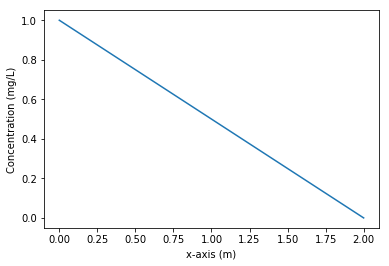

In [4]:
# Here is an example of how to initialize and use the function.
c_left = 1  # This is the left boundary condition
c_right = 0  # This is the right boundary condition
n = 51 # This is the amount of cells
Diff = 2e-9 # This is the diffusion coefficicent
Width = 2 # This is the width
poro = 0.4  # This is the porosity

x = np.linspace(0,Width,n) # this defines the array of x-values

### here is the crucial part. We are going to call the function we created
### and provide it with our defined parameters
A, b = Build_1D_Matrix(c_left, c_right, n, Diff, Width, poro)
### So here, A and b will be defined by the function, which returns A and b (you can use different name here if you want)
### ex: if you write, x,y = Build_1D_Matrix( ... ), 
### basically, it says that x = the first returned value of the function (A), 
### and y = the second value returned by the function (b). But here you can use whatever variable names you want.

# Basically we have set up our system of equation A c = b. Now we only need to solve it.
# There are numerical methods dedicated to that (we will study them in more depth later), but now, let's just use them
# Numpy has a set of linear algebra functions, one of which is "solve", which we use like this:

c = np.linalg.solve(A,b)
# this basically computes the solution of problem Ac = b and puts the values of the solution in an array c.

#Here is the plot of the result. You can see that on the left, c = 1, while on the right, c = 0 and observe a linear decrease.
plt.plot(x, c, label="Concentration")
plt.xlabel("x-axis (m)")
plt.ylabel("Concentration (mg/L)");

In [5]:
# Don't forget that you can always get help to  know what a function does,
help(Build_1D_Matrix)

Help on function Build_1D_Matrix in module __main__:

Build_1D_Matrix(c_left, c_right, n, D, Width, poro)
    Constructs a coefficient matrix A and an array b related to the problem Ac = b.
    Parameters:
    --------------
    c_left: (float)  left boundary condition for concentration [mg/L]
    c_right: (float) right boundary conditions for concentration [mg/L]
    n (int): amounts of cells/gridblocks [-]
    D (float): value of the diffusion coefficient (supposed the same everywhere) [m2/s]
    Width (float): Total physical width of the domain [m]
    poro (float): porosity value, supposed the same everywhere [-]
    Returns the matrix A, and the array b to solve the
    discretized 1D diffusion problem Ax = b
    ----------



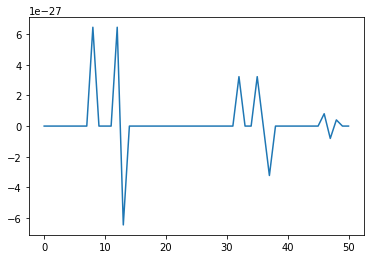

In [6]:
err = b-A.dot(c)
plt.plot(err)

# Assignment

## Taking into account a source term 

So far, our diffusion problem is simple: solute (like sulfate) is diffusing from the high concentration side to the low concentration side. But it is also possible that chemical reactions could be occurring to produce or consume sulfate within the problem domain. We now want to account for this so-called source of mass in our discrete approximation.

Our assignment consists of three parts. 

1. We want you to develop the correct 1-D steady-state discrete approximation stencil (W-C-E) in terms of concentrations for the situation where mass is being created within the domain by, for example, a chemical reaction.
2. We want you to modify the code to simulate diffusion with a so-called source term.
3. We want you to generalize the discrete approximation to 2 dimensions by adding N - S gridblocks above and below C.

### Production rates

For this problem, we will assume that in the zones where sulfate is being produced, the rate of production is given on a per mass of sediment basis. That is, for each kg of sediment, we assume that $xx~mg$ of sulfate is generated each second; or that the source is $q=xxx~mg/kg\cdot s$, (in words, the source is xxx mg of mass being produced for every kg of sediment every second). Assume that the bulk density of the porous sediment is $\rho_{bulk}=2000~kg/m^3$.  That is, the mass of sediments in $1~m^3$ of porous media is $2000~kg$. 

**Problem**: how much mass is produced every second in a gridblock of volume $v=5~m^3$? 

**Note** a negative rate indicates that mass is being consumed (for instance, sulfate could be consumed by sulfate-reducing bacteria).

**Source zone**

We will assume that there are reactive sulfide minerals only in the zone between $0.5 m$ and $1~m$, where 0 m corresponds to the bottom boundary. This source $q$ generates sulfate at a  rate of 2.5$\times$10$^{-9}$ $mg/(kg\cdot s)$. But this source is not located everywhere: only between 0.5 and 1 meter.


In [7]:
# We define a source as an array of n elements, who are all zeros.
Q = np.zeros(n)
# we assign every index between 0.5 and 1 meter (between 13-25) to the source
Q[13:25] = 5e-9 #mg/L/s

## 1. Add the source term to the discrete approximation


To determine how to account for a source in our discrete approximation, recall our steady-state statement in its most fundamental (total flux) form:

\begin{align}
J_{EC}+J_{WC} = 0\\
\end{align}

In words, this equation says: the *rate* of mass fluxing (either in or out) from E, plus the *rate* of mass fluxing either in or out from W sums to zero. Both $J_{WC}$ and $J_{EC}$ have dimensions of $\left[M\over T\right]$.

What if in addition to mass fluxing in and out by diffusion at rates $J_{WC}$ and $J_{EC}$, mass is also being created inside C at some rate $Q~\left[M\over T\right]$? How does the fundamental equation change?

If you get that, then you can follow the steps from earlier notebooks where we developed this stencil for the sitation where there is no source:

\begin{align}
&\left(D\theta {c_E - c_C \over \Delta x} +   D\theta {c_W - c_C \over \Delta x} \right) (\Delta y) (\Delta z) = 0 \\
\end{align}

We want you to write the equivalent stencil for the case where there is a source of mass $q ~ mg/(kg\cdot s)$. 




   

<div class="alert alert-info" >


**Your answer here**

Replace the 1-D steady-state fundamental equation below with the appropriate 1-D steady-state fundamental equation with a source term:
\begin{align}
J_{EC}+J_{WC} = 0\\
\end{align}
 
 
 

Replace the 1-D steady-state W-C-E stencil below with the appropriate 1-D steady-state W-C-E stencil with a source of mass per unit mass of sediment:



\begin{align}
&\left(D\theta {c_E - c_C \over \Delta x} +   D\theta {c_W - c_C \over \Delta x} \right) (\Delta y) (\Delta z) = 0 \\
\end{align}

</div>